## RNN with TensorFlow API

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### The Data

In [0]:
class TimeSeriesData():
    def __init__(self, num_points, xmin, xmax):
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/(num_points-1)
        self.x_data = np.linspace(xmin, xmax, num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true (self, series):
            return np.sin(series)
        
    def next_batch(self, batch_size, steps, step_index, return_batch_ts = False):
            period = self.num_points-steps
            batch_index = step_index%period
            y_batch = []
            for i in range(batch_size):
                
                y_batch.append(self.y_true[(batch_index+i)%period: (batch_index+i)%period+steps+1])
            y_batch = np.array(y_batch)  
            if return_batch_ts:
                return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1), self.x_data[batch_index: batch_index+steps+1].reshape(1,steps+1)
            else:
                return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1)
            

In [0]:
ts_data = TimeSeriesData(250, 0, 2*3.14*10)

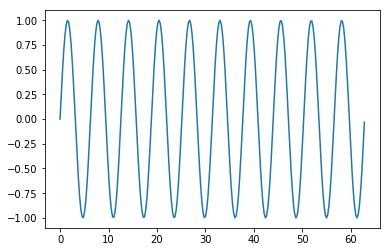

In [39]:
plt.plot(ts_data.x_data, ts_data.y_true)

In [0]:
#number of steps in batch 
num_time_steps = 25

In [0]:
y1, y2, ts =ts_data.next_batch(1, num_time_steps, 200, True)


In [42]:
y1.shape, y2.shape, ts.shape

((1, 25, 1), (1, 25, 1), (1, 26))

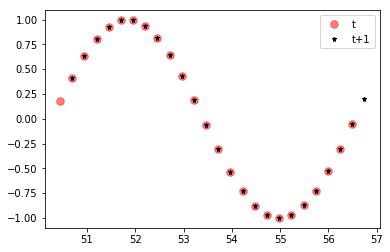

In [43]:
plt.plot(ts[0, :-1], y1[0, :], 'r.', markersize = 15, alpha= 0.5, label = 't')
plt.plot(ts[0, 1:], y2[0, :], 'k*', markersize = 5, label = 't+1')
plt.legend()

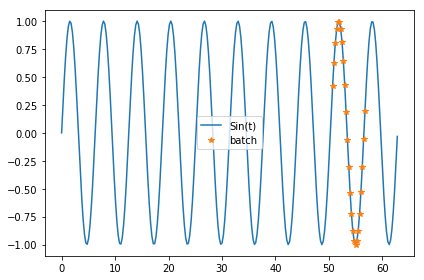

In [44]:
plt.plot(ts_data.x_data, ts_data.y_true, label = 'Sin(t)')
plt.plot(ts[0, 1:], y2[0, :], '*', label = 'batch')
plt.legend()
plt.tight_layout()

### Creating the Model

In [0]:
num_inputs = 1
num_neurons = 60
num_outputs=1
learning_rate = 0.0001 
batch_size = 4
num_train_interations = 2000
num_layers = 4

In [0]:
tf.reset_default_graph()

In [0]:
x = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs], name = 'x')
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])


In [0]:
def rnn_cell():
    cell = tf.contrib.rnn.BasicRNNCell(num_units = num_neurons, activation = tf.nn.leaky_relu)
    cell = tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=1.0, output_keep_prob=1.0, state_keep_prob=1.0)
    return cell
#create statcked rnn layers
stacked_rnn = tf.contrib.rnn.MultiRNNCell([rnn_cell() for _ in range(num_layers)])

In [0]:
cell = tf.contrib.rnn.OutputProjectionWrapper(stacked_rnn, output_size = num_outputs)


In [0]:
outputs, _ = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)
next_state = tf.identity(outputs, name='outputs_node')

In [0]:
loss = tf.reduce_mean(tf.square(outputs-y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [0]:
init = tf.global_variables_initializer()

In [0]:
saver = tf.train.Saver()

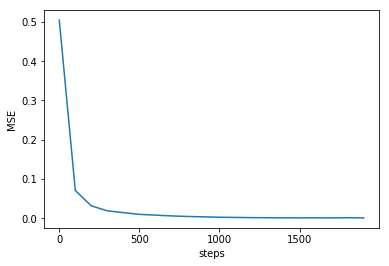

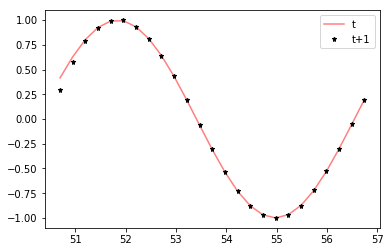

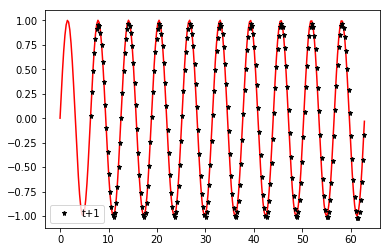

In [54]:
with tf.Session() as sess:
    sess.run(init)
    all_mse = []
    for iteration in range(num_train_interations):
    #for iteration in range(2):
        x_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps, iteration)
        sess.run(train, feed_dict={x:x_batch, y:y_batch})
        if iteration % 100 ==0:
            mse = loss.eval(feed_dict={x:x_batch, y:y_batch})
            all_mse.append(mse)
            #print (iteration, '\tMSE', mse)
    saver.save(sess, './rnn_time_series_model')
    plt.plot(range(0, 100*(0+len(all_mse)), 100), all_mse)
    plt.xlabel('steps')
    plt.ylabel('MSE')
    plt.xticks(list(range(0, 100*(0+len(all_mse)), 500)), labels = [str(i) for i in range(0, 100*(0+len(all_mse)), 500)])
    plt.show()
    
    x_new = y1.reshape(-1, num_time_steps, num_inputs)
    y_pred = sess.run(outputs, {x:x_new})

    plt.plot(ts[0, 1:], y2[0, :], 'r-', markersize = 15, alpha= 0.5, label = 't')
    plt.plot(ts[0, 1:], y_pred[0, :], 'k*', markersize = 5, label = 't+1')
    plt.legend()
    plt.show()

    training_instance = ts_data.y_true[:num_time_steps]
    for iteration in range(len(ts_data.y_true)-num_time_steps):
        x_new = training_instance[-num_time_steps:].reshape(1, -1).reshape(1, num_time_steps, num_inputs)
        prediction = sess.run(outputs, {x:x_new})[0, -1, 0]
        training_instance = np.append(training_instance, np.array([prediction]))

    plt.plot(ts_data.x_data, ts_data.y_true, 'r-')
    plt.plot(ts_data.x_data[num_time_steps:], training_instance[num_time_steps:], 'k*', markersize = 5, label = 't+1')
    plt.legend() 
    plt.show()

### Reload the saved model another time

### Predicting a time series t+1

In [0]:
#init=tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    saver = tf.train.import_meta_graph('./rnn_time_series_model.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    graph = tf.get_default_graph()
    x = graph.get_tensor_by_name('x:0')
    pred = graph.get_tensor_by_name('outputs_node:0')
    
    x_new = y1.reshape(-1, num_time_steps, num_inputs)
    y_pred = sess.run(pred, {x:x_new})

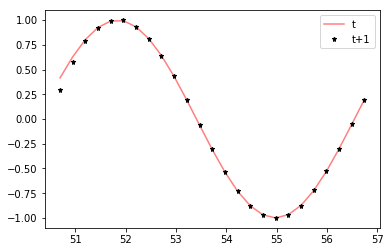

In [56]:
plt.plot(ts[0, 1:], y2[0, :], 'r-', markersize = 15, alpha= 0.5, label = 't')
plt.plot(ts[0, 1:], y_pred[0, :], 'k*', markersize = 5, label = 't+1')
plt.legend()


### Reproducing the training data

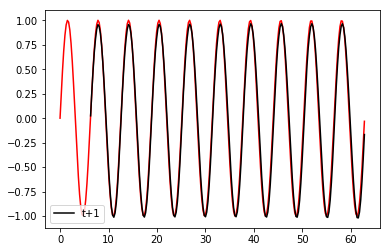

In [57]:
tf.reset_default_graph()
init=tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    saver = tf.train.import_meta_graph('./rnn_time_series_model.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    graph = tf.get_default_graph()
    x = graph.get_tensor_by_name('x:0')
    pred = graph.get_tensor_by_name('outputs_node:0')
    
    training_instance = ts_data.y_true[:num_time_steps]
    for iteration in range(len(ts_data.y_true)-num_time_steps):
        x_new = training_instance[-num_time_steps:].reshape(1, -1).reshape(1, num_time_steps, num_inputs)
        prediction = sess.run(pred, {x:x_new})[0, -1, 0]
        training_instance = np.append(training_instance, np.array([prediction]))

plt.plot(ts_data.x_data, ts_data.y_true, 'r-')
plt.plot(ts_data.x_data[num_time_steps:], training_instance[num_time_steps:], 'k-', markersize = 5, label = 't+1')
plt.legend()        
        